## LSTM Autoencoder

This notebook uses an LSTM autoencoder to model the normal behavior of the machine temperature time series. By training the model only on "normal" data, we reconstruct time windows, and flag periods with high reconstruction error as anomalies. The output is evaluated against labeled failures to compute precision, recall, and F1 score.
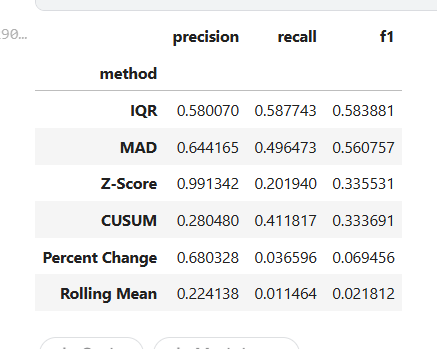

## Imports and load data

In [1]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# load data
url = "https://raw.githubusercontent.com/hjalalin/nab-anomaly-detection/main/data/realKnownCause/machine_temperature_system_failure.csv"
df = pd.read_csv(url)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

In [3]:
# Load labeled Anomaly Windows
url = "https://raw.githubusercontent.com/hjalalin/nab-anomaly-detection/main/data/labels/combined_windows.json"
response = requests.get(url)
labels = response.json()

anomaly_windows = [
    (pd.to_datetime(start), pd.to_datetime(end))
    for start, end in labels["realKnownCause/machine_temperature_system_failure.csv"]
]

In [4]:
torch.manual_seed(42)

## Train-Test Split and Scaling

We split the dataset chronologically to simulate a real-world early warning scenario.

Rather than using a random or fixed date-based cutoff, we explicitly remove all data points that fall within labeled anomaly windows. This ensures the autoencoder is trained solely on normal, healthy behavior — preventing it from learning patterns associated with failures and preserving the model’s ability to generalize to unseen anomalies.

The entire dataset — including the anomaly periods — is retained for evaluation, allowing us to assess how well the model distinguishes deviations from normal behavior.

Normalization is performed using Min-Max scaling. To avoid data leakage, the scaler is fit only on the clean training data. The same scaler is then applied to both training and test sets to maintain consistency.


In [5]:
early_warning_minutes = 60*5
gap_threshold = pd.Timedelta(minutes=5)

def is_in_any_window(ts, windows):
    return any(start - pd.Timedelta(minutes=early_warning_minutes) <= ts <= end for start, end in windows)

# Identify large gaps in the time index
df['delta'] = df.index.to_series().diff()
gap_indices = df[df['delta'] > gap_threshold].index

#  Build mask for anomaly windows + early warning windows
anomaly_mask = pd.Series(False, index=df.index)
for start, end in anomaly_windows:
    start_ew = start - pd.Timedelta(minutes=early_warning_minutes)
    anomaly_mask |= df.index.to_series().between(start_ew, end)

# Build mask for gaps
gap_mask = pd.Series(False, index=df.index)
for gap_time in gap_indices:
    gap_mask.loc[gap_time] = True
    # Optionally mask a few points before/after the gap to avoid sequence contamination
    pre_gap = gap_time - pd.Timedelta(minutes=gap_threshold.total_seconds() / 60)
    post_gap = gap_time + pd.Timedelta(minutes=gap_threshold.total_seconds() / 60)
    gap_mask |= df.index.to_series().between(pre_gap, post_gap)

# Combine masks for training
train_mask = (~anomaly_mask) #& (~gap_mask)

train_df = df[train_mask].copy()
test_df = df.copy()

# Step 5: Normalize
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df[['value']])
test_scaled = scaler.transform(test_df[['value']])

## Sequence Generation

The LSTM autoencoder works on sequences of time steps. We convert the continuous time-series into overlapping sequences of fixed length (e.g., 30 time steps). 

This allows the model to learn temporal dependencies and patterns of normal operating behavior.


In [6]:
def create_sequences(data, seq_len):
    xs = []
    for i in range(len(data) - seq_len):
        x = data[i:i+seq_len]
        xs.append(x)
    return np.array(xs)

In [7]:
def create_sequences_no_gaps(data_df, seq_len, gap_threshold=pd.Timedelta(minutes=10)):
    sequences = []
    timestamps = data_df.index

    # Step 1: Identify indices where gaps occur
    deltas = timestamps.to_series().diff()
    gap_indices = deltas[deltas > gap_threshold].index

    # Step 2: Split into continuous segments
    current_chunk = []
    for ts in timestamps:
        if ts in gap_indices and current_chunk:
            chunk = data_df.loc[current_chunk].values
            if len(chunk) >= seq_len:
                for i in range(len(chunk) - seq_len):
                    sequences.append(chunk[i:i+seq_len])
            current_chunk = []
        current_chunk.append(ts)
    if current_chunk:  # last chunk
        chunk = data_df.loc[current_chunk].values
        if len(chunk) >= seq_len:
            for i in range(len(chunk) - seq_len):
                sequences.append(chunk[i:i+seq_len])

    return np.array(sequences)


In [8]:
SEQ_LEN = 75

# Use already normalized train_df
X_train = create_sequences_no_gaps(
    pd.DataFrame(train_scaled, index=train_df.index, columns=['value']),
    seq_len=SEQ_LEN
)
X_test = create_sequences(  
    test_scaled,
    seq_len=SEQ_LEN
)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)


## LSTM Autoencoder Architecture

The model has two parts:
- **Encoder**: Compresses input sequences into a low-dimensional representation.
- **Decoder**: Attempts to reconstruct the original sequence from this representation.

During inference, high reconstruction error suggests that the current sequence deviates from learned normal behavior — a potential anomaly.


In [9]:
# dataloader
train_loader = DataLoader(TensorDataset(X_train_tensor, X_train_tensor), batch_size=64, shuffle=True)

In [10]:
class LSTMAutoencoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64, dropout=0.2, num_layers=2):
        super(LSTMAutoencoder, self).__init__()
        self.seq_len = seq_len
        self.n_features = n_features
        self.embedding_dim = embedding_dim

        # Encoder LSTM + LayerNorm
        self.encoder_lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=embedding_dim,
            batch_first=True,
            dropout=dropout,
            num_layers=num_layers 
        )
        self.encoder_norm = nn.LayerNorm(embedding_dim)

        # Dropout after encoder
        self.dropout = nn.Dropout(p=dropout)

        # Decoder LSTM
        self.decoder_lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=n_features,
            batch_first=True,
            dropout=dropout,
            num_layers=num_layers
        )

    def forward(self, x):
        # Encoder
        encoded_seq, _ = self.encoder_lstm(x)
        encoded_seq = self.encoder_norm(encoded_seq)

        # Decoder
        decoded_seq, _ = self.decoder_lstm(encoded_seq)
        return decoded_seq


model = LSTMAutoencoder(seq_len=SEQ_LEN, n_features=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

## Model Training

We use Mean Squared Error (MSE) as the loss function. The model is trained using Adam optimizer over several epochs. 

The goal is to minimize the reconstruction loss on normal sequences. We expect the model to poorly reconstruct anomalous patterns during inference.


In [11]:
n_epochs = 50
for epoch in range(n_epochs):
    model.train()
    losses = []
    for batch_X, _ in train_loader:
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_X)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    print(f"Epoch {epoch+1}, Loss: {np.mean(losses):.5f}")

Epoch 1, Loss: 0.22372
Epoch 2, Loss: 0.16937
Epoch 3, Loss: 0.12355
Epoch 4, Loss: 0.08986
Epoch 5, Loss: 0.06644
Epoch 6, Loss: 0.05134
Epoch 7, Loss: 0.04206
Epoch 8, Loss: 0.03674
Epoch 9, Loss: 0.02937
Epoch 10, Loss: 0.02135
Epoch 11, Loss: 0.01837
Epoch 12, Loss: 0.01636
Epoch 13, Loss: 0.01497
Epoch 14, Loss: 0.01394
Epoch 15, Loss: 0.01319
Epoch 16, Loss: 0.01265
Epoch 17, Loss: 0.01225
Epoch 18, Loss: 0.01196
Epoch 19, Loss: 0.01174
Epoch 20, Loss: 0.01161
Epoch 21, Loss: 0.01148
Epoch 22, Loss: 0.01139
Epoch 23, Loss: 0.01129
Epoch 24, Loss: 0.01121
Epoch 25, Loss: 0.01109
Epoch 26, Loss: 0.01099
Epoch 27, Loss: 0.01088
Epoch 28, Loss: 0.01078
Epoch 29, Loss: 0.01066
Epoch 30, Loss: 0.01056
Epoch 31, Loss: 0.01045
Epoch 32, Loss: 0.01039
Epoch 33, Loss: 0.01028
Epoch 34, Loss: 0.01015
Epoch 35, Loss: 0.01005
Epoch 36, Loss: 0.00995
Epoch 37, Loss: 0.00987
Epoch 38, Loss: 0.00977
Epoch 39, Loss: 0.00966
Epoch 40, Loss: 0.00957
Epoch 41, Loss: 0.00948
Epoch 42, Loss: 0.00939
E

In [12]:
model.eval()
with torch.no_grad():
    X_pred = model(X_test_tensor).numpy()
    
mse = np.mean(np.power(X_test - X_pred, 2), axis=(1,2))
errors = pd.Series(mse, index=test_df.index[SEQ_LEN:])


## Anomaly Detection

We set a fixed threshold based on the 95th percentile of reconstruction error. Any time window with an error above this threshold is flagged as anomalous.

The choice of threshold is critical — too low leads to false alarms, too high may miss genuine faults. This threshold can be optimized later using precision-recall tradeoffs.


In [13]:
def score_with_windows(detected_times, windows, full_index):
    # Build ground truth vector
    y_true = pd.Series(False, index=full_index)
    for start, end in windows:
        y_true[(full_index >= start) & (full_index <= end)] = True

    # Build prediction vector
    y_pred = pd.Series(full_index.isin(detected_times), index=full_index)

    # Compute metrics
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    return {"precision": precision, "recall": recall, "f1": f1}


In [14]:
# Build ground truth label vector based on anomaly windows
y_true = pd.Series(False, index=errors.index)
for start, end in anomaly_windows:
    y_true[(errors.index >= start) & (errors.index <= end)] = True

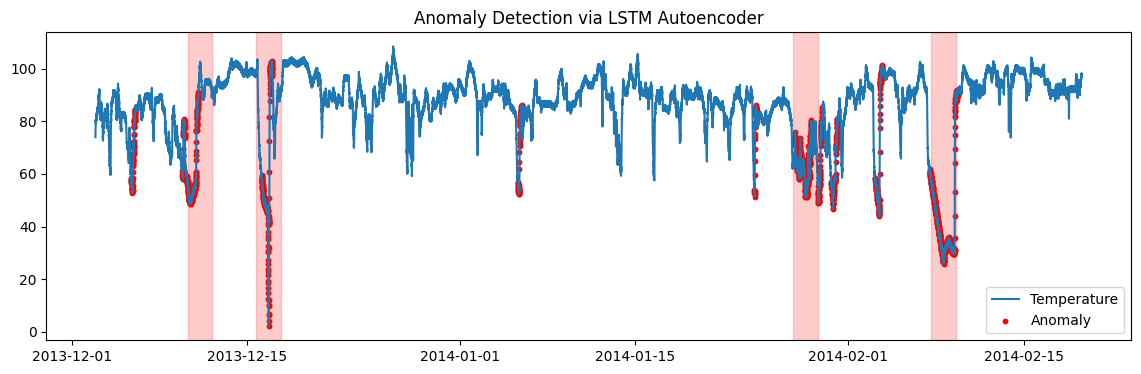

In [15]:
# threshold = np.percentile(mse, 97) 
precision, recall, thresholds = precision_recall_curve(y_true, errors)
f1_scores = 2 * (precision * recall) / (precision + recall)
best_idx = np.argmax(f1_scores)
threshold = thresholds[best_idx]

anomalies = errors > threshold

plt.figure(figsize=(14, 4))
plt.plot(df.index, df["value"], label="Temperature")
plt.scatter(errors.index[anomalies], df.loc[errors.index[anomalies]]["value"], color='r', label="Anomaly", s=10)
# Highlight anomaly windows
for start, end in anomaly_windows:
    plt.axvspan(start, end, color='red', alpha=0.2)
plt.legend()
plt.title("Anomaly Detection via LSTM Autoencoder")
plt.show()


In [16]:
full_index = df.index[SEQ_LEN:]
detected_anomaly_times = errors.index[errors > threshold]

# Compute metrics
score = score_with_windows(detected_anomaly_times, anomaly_windows, full_index)

# Print
print(f"Threshold:  {threshold:.3f}")
print(f"Precision: {score['precision']:.3f}")
print(f"Recall:    {score['recall']:.3f}")
print(f"F1 Score:  {score['f1']:.3f}")


Threshold:  0.032
Precision: 0.639
Recall:    0.638
F1 Score:  0.638


In [17]:

def plot_reconstruction_error_distribution(reconstruction_errors, y_true, bins=100):
    # Convert to DataFrame for convenience
    df = pd.DataFrame({
        'reconstruction_error': reconstruction_errors,
        'anomaly': y_true.astype(bool)
    })

    plt.figure(figsize=(10, 5))
    sns.histplot(data=df, x="reconstruction_error", hue="anomaly", bins=bins, 
                 stat="density", common_norm=False, palette={False: 'blue', True: 'red'}, alpha=0.5)
    plt.title("Reconstruction Error Distribution")
    plt.xlabel("Reconstruction Error")
    plt.ylabel("Density")
    plt.legend(labels=["Normal", "Anomaly"])
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [18]:
#plot_reconstruction_error_distribution(errors, y_true.values)